In [41]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import glob
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)
print(np.__version__)
print("PIL 라이브러리 import 완료!")

2.6.0
1.22.2
PIL 라이브러리 import 완료!


In [43]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")
	print(len(images), " images to be resized.")

	# 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		# Image.ANTIALIAS 대신 Image.LANCZOS 사용 권장 (품질 높은 리사이징)
		new_img=old_img.resize(target_size, Image.LANCZOS)
		new_img.save(img, "JPEG") # 원본 파일 위에 덮어쓰기

	print(len(images), " images resized.")

# 모든 이미지 리사이즈 (가정: 훈련 데이터 경로)
image_dir_path_train_base = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
resize_images(image_dir_path_train_base + "/scissor")
resize_images(image_dir_path_train_base + "/rock")
resize_images(image_dir_path_train_base + "/paper")
print("훈련 이미지 resize 완료!")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
훈련 이미지 resize 완료!


In [44]:
def load_data(img_path, number_of_data):  # number_of_data를 명시적으로 받도록 수정
	# 가위 : 0, 바위 : 1, 보 : 2
	img_size=28
	color=3
	# 배열 생성: (데이터 개수, 28, 28, 3)
	imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
	labels=np.zeros(number_of_data,dtype=np.int32)

	idx=0
	# --- 가위(0) 이미지 로드 ---
	for file in glob.iglob(img_path+'/scissor/*.jpg'):
		if idx == number_of_data: break # 안전 장치: 인덱스 초과 방지
		img = np.array(Image.open(file),dtype=np.int32)
		imgs[idx,:,:,:]=img
		labels[idx]=0
		idx=idx+1

	# --- 바위(1) 이미지 로드 ---
	for file in glob.iglob(img_path+'/rock/*.jpg'):
		if idx == number_of_data: break
		img = np.array(Image.open(file),dtype=np.int32)
		imgs[idx,:,:,:]=img
		labels[idx]=1
		idx=idx+1

	# --- 보(2) 이미지 로드 ---
	for file in glob.iglob(img_path+'/paper/*.jpg'):
		if idx == number_of_data: break
		img = np.array(Image.open(file),dtype=np.int32)
		imgs[idx,:,:,:]=img
		labels[idx]=2
		idx=idx+1

	print("로드된 이미지 개수는", idx,"입니다.")
    # 실제 로드된 개수까지만 잘라서 반환하여 불필요한 0 패딩 방지
	return imgs[:idx], labels[:idx]

TRAIN_DATA_COUNT = 300
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"

(x_train_raw, y_train)=load_data(image_dir_path, number_of_data=TRAIN_DATA_COUNT)

# 핵심: 정규화 (0~255 값을 0.0~1.0으로 스케일링)
x_train = x_train_raw/255.0  

print("\n--- 훈련 데이터 정보 ---")
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

로드된 이미지 개수는 300 입니다.

--- 훈련 데이터 정보 ---
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


라벨:  0


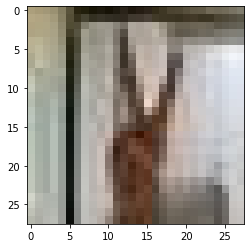

In [45]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [46]:
# 하이퍼파라미터 튜닝 (채널 및 뉴런 수 증가)
n_channel_1=32 # 16 -> 32로 증가
n_channel_2=64 # 32 -> 64로 증가
n_dense=128    # 32 -> 128로 증가
n_train_epoch=20 # Epoch 증가

model=keras.models.Sequential()
# Convolutional Layer 1
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D((2,2)))

# Convolutional Layer 2
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

# Flatten Layer: 2차원 Feature Map을 1차원 벡터로 변환
model.add(keras.layers.Flatten())

# Dropout Layer (과적합 방지): Flatten 후 Dense 층 앞에 적용
model.add(keras.layers.Dropout(0.25))

# Dense Layer 1 (Hidden Layer)
model.add(keras.layers.Dense(n_dense, activation='relu'))

# Dropout Layer 2 (과적합 방지)
model.add(keras.layers.Dropout(0.25)) 

# Dense Layer 2 (Output Layer)
# 출력 클래스 3개 (가위, 바위, 보)에 대해 확률 분포를 얻기 위해 Softmax 사용
model.add(keras.layers.Dense(3, activation='softmax'))

print("\n--- 모델 구조 (CNN + Dropout 적용) ---")
model.summary()


--- 모델 구조 (CNN + Dropout 적용) ---
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)     

In [47]:
# 최적화 및 손실 함수 설정
model.compile(optimizer='adam',                   # 최적화: Adam (효율적인 경사 하강법 기반)
              loss='sparse_categorical_crossentropy', # 손실 함수: 정수형 라벨을 사용하는 다중 분류
              metrics=['accuracy'])              # 평가 지표: 정확도

# 🚀 데이터 증강 (Data Augmentation) 객체 생성 및 적용
# 주석: 적은 데이터셋 문제를 해결하기 위해 필수적입니다.
datagen = ImageDataGenerator(
    rotation_range=15,       # 15도 이내 회전
    zoom_range=0.1,          # 10% 이내 확대/축소
    width_shift_range=0.1,   # 가로 이동
    height_shift_range=0.1,  # 세로 이동
    horizontal_flip=True,    # 좌우 반전
    fill_mode='nearest'
)

# 배치 사이즈 설정
BATCH_SIZE = 32 # 2의 제곱수 사용

# 모델 훈련: fit 대신 fit_generator (혹은 flow)를 사용하여 증강된 데이터로 학습
print("\n--- 모델 훈련 (데이터 증강 적용) ---")
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    epochs=n_train_epoch,
    steps_per_epoch=int(np.ceil(TRAIN_DATA_COUNT / BATCH_SIZE))
)


--- 모델 훈련 (데이터 증강 적용) ---
Epoch 1/20
10/10 [==============================] - 1s 47ms/step - loss: 1.0883 - accuracy: 0.3967
Epoch 2/20
10/10 [==============================] - 1s 51ms/step - loss: 1.0560 - accuracy: 0.4900
Epoch 3/20
10/10 [==============================] - 0s 48ms/step - loss: 1.0173 - accuracy: 0.4800
Epoch 4/20
10/10 [==============================] - 0s 47ms/step - loss: 0.9899 - accuracy: 0.5100
Epoch 5/20
10/10 [==============================] - 0s 49ms/step - loss: 0.8952 - accuracy: 0.6400
Epoch 6/20
10/10 [==============================] - 0s 47ms/step - loss: 0.7938 - accuracy: 0.7167
Epoch 7/20
10/10 [==============================] - 1s 50ms/step - loss: 0.6509 - accuracy: 0.7700
Epoch 8/20
10/10 [==============================] - 0s 48ms/step - loss: 0.6217 - accuracy: 0.7700
Epoch 9/20
10/10 [==============================] - 0s 47ms/step - loss: 0.5620 - accuracy: 0.8033
Epoch 10/20
10/10 [==============================] - 0s 46ms/step - loss: 0.5248 -

In [51]:
# 훈련 데이터와 동일하게 테스트 데이터도 리사이징해야 합니다. (실제 환경에서 실행 필요)
image_dir_path_test = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
resize_images(image_dir_path_test + "/scissor")
resize_images(image_dir_path_test + "/rock")
resize_images(image_dir_path_test + "/paper")

# 테스트 데이터도 총 313개라고 가정 (실제 개수에 맞게 수정 필요)
TEST_DATA_COUNT = 313 

(x_test_raw, y_test)=load_data(image_dir_path_test, number_of_data=TEST_DATA_COUNT)
x_test = x_test_raw/255.0  # 정규화 적용

print("\n--- 테스트 데이터 정보 ---")
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

# 모델 성능 평가
print("\n--- 모델 성능 평가 ---")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {} ".format(test_accuracy))

107  images to be resized.
107  images resized.
102  images to be resized.
102  images resized.
104  images to be resized.
104  images resized.
로드된 이미지 개수는 313 입니다.

--- 테스트 데이터 정보 ---
x_test shape: (313, 28, 28, 3)
y_test shape: (313,)

--- 모델 성능 평가 ---
10/10 - 0s - loss: 1.3788 - accuracy: 0.5974
test_loss: 1.378796935081482 
test_accuracy: 0.5974441170692444 
